# Pretraitement des donnees

In [469]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import radon
from skimage import io, color, filters
import cv2

def charger_images(dossier):
    images = []
    labels = []  

    for nom_personne in os.listdir(dossier):
        dossier_personne = os.path.join(dossier, nom_personne)
        
        if not os.path.isdir(dossier_personne):
            continue

        for nom_fichier in os.listdir(dossier_personne):
            chemin_image = os.path.join(dossier_personne, nom_fichier)
            if not nom_fichier.endswith(('.png', '.jpg', '.jpeg', '.PNG')):
                continue

            image = Image.open(chemin_image)
            images.append(image)
            labels.append(nom_personne)
            
    return images, labels

# Chemin vers le dossier
dossier_train = "train_test"

# Charger les images et les étiquettes depuis le dossier train_test
image_train_test, labels_train_test = charger_images(dossier_train)

# Convertir les images en tableaux NumPy
train_test_array = [np.array(image) for image in image_train_test]

# Rendre les images array en des images carrees de meme taille
train_test_array = [cv2.resize(image,(500,500)) for image in train_test_array]

# Passer du niveaux en couleurs en niveaux de gris
train_test_gray = [cv2.cvtColor(image,cv2.COLOR_BGR2GRAY) for image in train_test_array]

# Filtrer le bruit des images avec un filtre median
train_test_filtree = [cv2.medianBlur(image,5) for image in train_test_gray]

# Binariser l'ensemble des images de training/test pour reduire la complexité de calcul des sinogrammes
train_test_binary = [cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1] for image in train_test_filtree]

# Déterminer les contours des signatures dans les images
train_test_contours = [cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0] for image in train_test_binary]

# Dessiner les contours des signatures sur les images
p = len(train_test_contours)
train_test_draw = [cv2.drawContours(train_test_binary[i], train_test_contours[i], -1, (255, 255, 255), 2) for i in range(p)]

# Calculer la transformée de Radon des images de training
    # Construire un ensemble de 180 angles de projections
theta = np.linspace(0., 180., 180, endpoint = False)
    # Construire les sinogrammes du training avec des projections le long d'une droite à chaque angle de projection donnée
train_test_radon = [radon(image, theta = theta, circle = False) for image in train_test_draw]

# Sauvegarde des sinogrammes de training/test en cas d'eventuelles nouvelles analyses

In [472]:
Categories = []

Labels = []

for j in labels_train_test:
    
    if j not in Labels :
        L = [i for i in labels_train_test if(i==j)]
        Categories.append(L)
        Labels.append(j)


k = 0
q = 0
for L in Categories:
    dossier = "train_test_" + L[0]
    os.makedirs(dossier)
    
    k += len(L)
    subset = train_test_radon[q:k]
    
    length = len(subset)
    for s in range(length):
        norm_matrix = (subset[s] - np.min(subset[s])) / (np.max(subset[s]) - np.min(subset[s])) * 255
        image = Image.fromarray(norm_matrix.astype('uint8'))
        im_format = 'sinog_' + str(s+1) + '.bmp'
        dest = os.path.join(dossier,im_format)
        image.save(dest)
        
    q = k

# Statistiques de l'ensemble training_test

In [473]:
Statistiques = []

Id = [i for i in range(len(Labels))]

for L in Categories:
    Statistiques.append(len(L))

Name = np.array(['Id','Classe','Occurence'])

Resume_train_test = np.array(Labels)
Resume_train_test = np.vstack((Resume_train_test,np.array(Statistiques)))
Resume_train_test = np.vstack((np.array(Id),Resume_train_test))
Resume_train_test = np.c_[Name.T,Resume_train_test]

folder1 = "Statistiques_train_test1.csv"
folder2 = "Statistiques_train_test2.txt"

np.savetxt(folder1, Resume_train_test, fmt = '%s', delimiter = ',')
np.savetxt(folder2, Resume_train_test, fmt = '%s', delimiter = '\t')

In [7]:
import pandas as pd

Stats = pd.read_table("Statistiques_train_test2.txt", header = None)
Stats.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,Id,0,1,2,3,4,5,6,7,8,...,118,119,120,121,122,123,124,125,126,127
1,Classe,1,001_forg,2,002_forg,3,003_forg,4,004_forg,6,...,65,065_forg,66,066_forg,67,067_forg,68,068_forg,69,069_forg
2,Occurence,24,8,24,12,24,12,24,11,24,...,12,8,12,16,12,8,12,8,12,12


# Utilisation d'un réseau de neurones CNN pour la classification

    # Augmentation de nos données pour une bonne généralisation

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
import os
import cv2

datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

def data_augmentate(dossier):
    
    labels_train_test = []
    augmented_data = []
    images = []
    
    classe = 1
    
    for nom_personne in os.listdir(dossier):
        dossier_personne = os.path.join(dossier, nom_personne)
        
        if not os.path.isdir(dossier_personne):
            continue

        for nom_fichier in os.listdir(dossier_personne):
            chemin_image = os.path.join(dossier_personne, nom_fichier)
            if not nom_fichier.endswith(('.bmp')):
                continue

            image = Image.open(chemin_image)
            images.append(image)
        
        images = [np.array(image) for image in images]
        images = [ cv2.resize(image, (100,100)) for image in images]
        images = [list(image.flatten()) for image in images]
        images = np.array(images)
        
        images_reshaped = images.reshape(-1, 100, 100, 1)

        for i in range(images_reshaped.shape[0]):
            # Obtenir une image
            img = images_reshaped[i]

            augmented_data.append(img.flatten().tolist())
            labels_train_test.append(classe)
            
            # Ajouter une dimension supplémentaire pour le lot
            img = np.expand_dims(img, axis = 0)
            
            # Générer 10 images augmentées de l'image
            for k in range(10):
                augmented_image = datagen.flow(img, batch_size = 1).next()[0]
                # Ajouter l'image augmentée au tableau
                augmented_data.append(augmented_image.flatten().tolist())
                
                labels_train_test.append(classe)
        
        images = [] 
        classe += 1
        
    # Transformer la liste en un tableau NumPy
    augmented_data = np.array(augmented_data)
    
    labels_train_test = np.array(labels_train_test)
    
    return augmented_data, labels_train_test

data, labels = data_augmentate("sinogram_train_test")

In [2]:
print(data.shape)
print(labels.shape)

(18139, 10000)
(18139,)


In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
import os
import cv2

def load_sinogramme(dossier):
    
    labels_train_test = []
    data = []
    images = []
    
    classe = 1
    
    for nom_personne in os.listdir(dossier):
        dossier_personne = os.path.join(dossier, nom_personne)
        
        if not os.path.isdir(dossier_personne):
            continue

        for nom_fichier in os.listdir(dossier_personne):
            chemin_image = os.path.join(dossier_personne, nom_fichier)
            if not nom_fichier.endswith(('.bmp')):
                continue

            image = Image.open(chemin_image)
            images.append(image)
        
        images = [np.array(image) for image in images]
        images = [ cv2.resize(image, (100,100)) for image in images]

        for image in images:
            data.append(list(image.flatten()))
            labels_train_test.append(classe)
        
        
        images = [] 
        classe += 1
        
    # Transformer la liste en un tableau NumPy
    data = np.array(data)
    
    labels_train_test = np.array(labels_train_test)
    
    return data, labels_train_test

data, labels = load_sinogramme("sinogram_train_test")

In [2]:
print(data.shape)
print(labels.shape)

(1649, 10000)
(1649,)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encoder les etiquettes-Creation d'uns instance de "LabelEncoder()"
label_encoder = LabelEncoder()

labels_integer = label_encoder.fit_transform(labels)
labels_one_hot = to_categorical(labels_integer)

train, test, ytrain, ytest = train_test_split(data, labels_one_hot, test_size = 0.33, random_state = 42, shuffle = True)

train = train.reshape(train.shape[0], 100, 100, 1)
test = test.reshape(test.shape[0], 100, 100, 1)

# Créez le modèle CNN
model = Sequential()

# Ajoutez une couche de convolution avec activation ReLU
model.add(Conv2D(64, (3, 3), activation = 'relu', input_shape = (100, 100, 1)))

# Ajoutez une couche de pooling pour réduire la dimension spatiale
model.add(MaxPooling2D((3, 3)))

# Ajoutez une autre couche de convolution avec activation ReLU
model.add(Conv2D(64, (3, 3), activation='relu'))

# Ajoutez une autre couche de pooling
model.add(MaxPooling2D((3, 3)))

# Aplatir les données avant de passer à la couche dense
model.add(Flatten())

# Ajouter une couche de "dropout" pour eviter l'overfitting
model.add(Dropout(0.8))

# Ajoutez une couche dense avec activation ReLU
model.add(Dense(200, activation = 'relu'))

# Ajoutez la couche de sortie avec activation softmax pour la classification
model.add(Dense(128, activation = 'softmax'))

# Compilez le modèle avec la fonction de perte et l'optimiseur appropriés
model.compile(optimizer = 'adam', loss ='categorical_crossentropy', metrics = ['accuracy'])

# Entraînez le modèle avec vos données
model.fit(train, ytrain, epochs = 250, batch_size = 90, validation_data = (test, ytest))

# Évaluer le modèle sur l'ensemble de training/test
train_loss, train_accuracy = model.evaluate(train, ytrain)
test_loss, test_accuracy = model.evaluate(test, ytest)

print(f'Train Accuracy: {train_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/250
13/13 [==============================] - 16s 1s/step - loss: 21.0988 - accuracy: 0.0054 - val_loss: 4.8516 - val_accuracy: 0.0037
Epoch 2/250
13/13 [==============================] - 9s 708ms/step - loss: 4.8774 - accuracy: 0.0082 - val_loss: 4.8528 - val_accuracy: 0.0073
Epoch 3/250
13/13 [==============================] - 9s 720ms/step - loss: 4.8510 - accuracy: 0.0118 - val_loss: 4.8534 - val_accuracy: 0.0055
Epoch 4/250
13/13 [==============================] - 10s 767ms/step - loss: 4.8477 - accuracy: 0.0172 - val_loss: 4.8524 - val_accuracy: 0.0055
Epoch 5/250
13/13 [==============================] - 9s 699ms/step - loss: 4.8431 - accuracy: 0.0163 - val_loss: 4.8516 - val_accuracy: 0.0055
Epoch 6/250
13/13 [==============================] - 9s 699ms/step - loss: 4.8408 - accuracy: 0.0163 - val_loss: 4.8521 - val_accuracy: 0.0055
Epoch 7/250
13/13 [==============================] - 9s 658ms/step - loss: 4.8370 - accuracy: 0.0190 - val_loss: 4.8520 - val_accuracy: 0.0037

In [23]:
import joblib

joblib.dump(label_encoder, "label_encoder_signature.joblib")
model.save("Model_signature.keras")

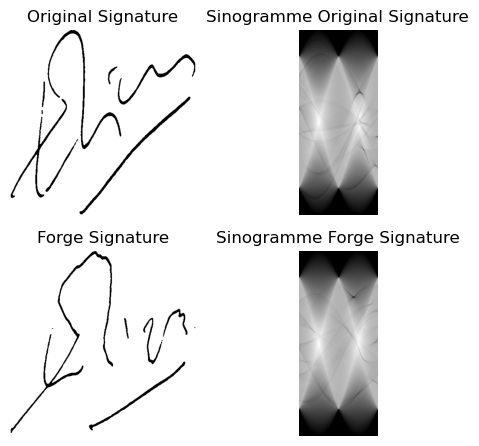

In [32]:
import cv2
from skimage.transform import radon
import numpy as np


img1, img2 = cv2.imread("Origine.png"), cv2.imread("Forge.png")
L = [img1, img2]

def plot(L):
    k = 1
    for image in L:
        
        img_array = cv2.resize(image,(500,500))
        
        # Passer du niveaux en couleurs en niveaux de gris
        img_gray = cv2.cvtColor(img_array,cv2.COLOR_BGR2GRAY)
        
        # Filtrer le bruit des images avec un filtre median
        img_filtree = cv2.medianBlur(img_gray,5)
        
        # Binariser l'ensemble des images de training/test pour reduire la complexité de calcul des sinogrammes
        img_binary = cv2.threshold(img_filtree, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
       
        # Déterminer les contours des signatures dans les images
        img_contours = cv2.findContours(img_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
        
        # Dessiner les contours des signatures sur les images
        img_draw = cv2.drawContours(img_binary, img_contours, -1, (255, 255, 255), 2)
        plt.subplot(2, 2, k)
        plt.imshow(img_draw, cmap = 'gray')
        if(k == 1):
            plt.title('Original Signature')
        if(k == 3):
            plt.title('Forge Signature')
        
            
        plt.tight_layout()
        plt.axis('off')
        k = k + 1
        # Calculer la transformée de Radon des images de training
            # Construire un ensemble de 180 angles de projections
        theta = np.linspace(0., 180., 300, endpoint = False)
            # Construire les sinogrammes du training avec des projections le long d'une droite à chaque angle de projection donnée
        img_radon = radon(img_draw, theta = theta, circle = False)
        
        norm_matrix = (img_radon - np.min(img_radon)) / (np.max(img_radon) - np.min(img_radon)) * 255
        img_norm = norm_matrix.astype('uint8')
        plt.subplot(2, 2, k)
        plt.imshow(img_norm, cmap = 'gray')
        if(k == 2):
            plt.title('Sinogramme Original Signature')
        if(k == 4):
            plt.title('Sinogramme Forge Signature')
        plt.tight_layout()
        plt.axis('off')
        k = k + 1
plot(L)

1/1 [==============================] - 23s 23s/step
[1]


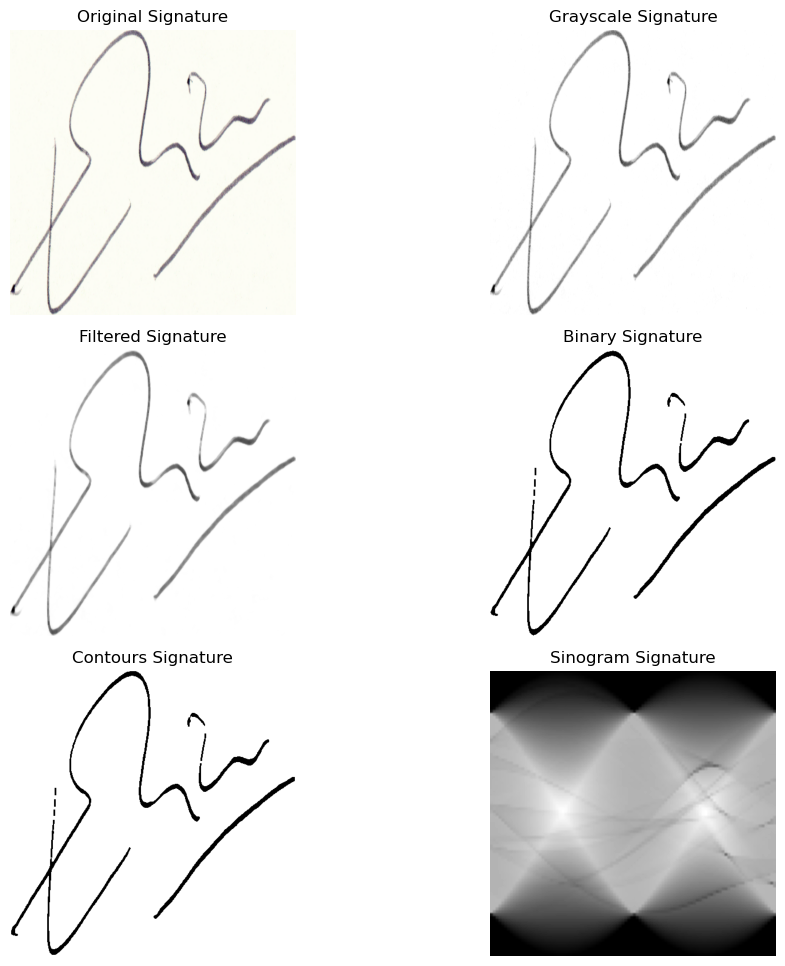

In [28]:
from tensorflow.keras.models import load_model
import joblib
import cv2
from skimage.transform import radon

model = load_model("Model_signature.keras")
label_encoder = joblib.load("label_encoder_signature.joblib")

img = cv2.imread("1.png")

def predict(image):

    plt.figure(figsize = (15,10))
    # Rendre les images array en des images carrees de meme taille
    img_array = cv2.resize(image,(500,500))
    plt.subplot(321)
    plt.imshow(img_array)
    plt.title('Original Signature')
    plt.tight_layout()
    plt.axis('off')
    
    # Passer du niveaux en couleurs en niveaux de gris
    img_gray = cv2.cvtColor(img_array,cv2.COLOR_BGR2GRAY)
    plt.subplot(322)
    plt.imshow(img_gray, cmap = 'gray')
    plt.title('Grayscale Signature')
    plt.tight_layout()
    plt.axis('off')
    
    # Filtrer le bruit des images avec un filtre median
    img_filtree = cv2.medianBlur(img_gray,5)
    plt.subplot(323)
    plt.imshow(img_filtree, cmap = 'gray')
    plt.title('Filtered Signature')
    plt.tight_layout()
    plt.axis('off')
    
    # Binariser l'ensemble des images de training/test pour reduire la complexité de calcul des sinogrammes
    img_binary = cv2.threshold(img_filtree, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    plt.subplot(324)
    plt.imshow(img_binary, cmap = 'gray')
    plt.title('Binary Signature')
    plt.tight_layout()
    plt.axis('off')
    
    # Déterminer les contours des signatures dans les images
    img_contours = cv2.findContours(img_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    
    # Dessiner les contours des signatures sur les images
    img_draw = cv2.drawContours(img_binary, img_contours, -1, (255, 255, 255), 2)
    plt.subplot(325)
    plt.imshow(img_draw, cmap = 'gray')
    plt.title('Contours Signature')
    plt.tight_layout()
    plt.axis('off')
    
    # Calculer la transformée de Radon des images de training
        # Construire un ensemble de 180 angles de projections
    theta = np.linspace(0., 180., 180, endpoint = False)
        # Construire les sinogrammes du training avec des projections le long d'une droite à chaque angle de projection donnée
    img_radon = radon(img_draw, theta = theta, circle = False)
    
    norm_matrix = (img_radon - np.min(img_radon)) / (np.max(img_radon) - np.min(img_radon)) * 255
    img_norm = norm_matrix.astype('uint8')
    
    img_array = cv2.resize(img_norm,(100,100))
    plt.subplot(326)
    plt.imshow(img_array, cmap = 'gray')
    plt.title('Sinogram Signature')
    plt.tight_layout()
    plt.axis('off')
    
    array = img_array.reshape(1,100,100,1)

    integer = model.predict(array).argmax(axis = 1)
    
    y = label_encoder.inverse_transform(integer)
    print(y)

predict(img)

In [ ]:
import PySimpleGUI as sg
import cv2
import tensorflow as tf
import numpy as np
import io
from PIL import Image as PILImage
from PIL import ImageTk
from skimage.transform import radon
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('C:/Users/Khali/RF/my_trained_model.h5')

# Set a custom PySimpleGUI theme for a nicer look
sg.theme('DarkBlue1')

# Define the layout with larger elements
layout = [
    [sg.Text("Please enter an image file:", size=(30, 1))],
    [sg.Input(key='-IMAGE-', size=(30, 1)), sg.FileBrowse(file_types=(("Image Files", "*.png *.jpg *.jpeg *.gif"),))],
    [sg.Button("Generate Sinogram", size=(15, 1)), sg.Button("Predict Sinogram", size=(15, 1)), sg.Button("Exit", size=(10, 1))],
    [sg.Image(key='-SINOGRAM-', size=(300, 300))],
    [sg.Text("Prediction: ", size=(30, 1)), sg.Text("", key='-PREDICTION-', size=(40, 1), justification='left')],
]

window = sg.Window("Image Forgery Detection", layout, finalize=True)

while True:
    event, values = window.read()

    if event == sg.WIN_CLOSED or event == 'Exit':
        break
    elif event == 'Generate Sinogram':
        image_path = values['-IMAGE-']
        try:
            input_image = cv2.imread(image_path)
            # Rendre les images array en des images carrees de meme taille
            img_array = cv2.resize(input_image,(500,500))
            
            # Passer du niveaux en couleurs en niveaux de gris
            img_gray = cv2.cvtColor(img_array,cv2.COLOR_BGR2GRAY)
            
            # Filtrer le bruit des images avec un filtre median
            img_filtree = cv2.medianBlur(img_gray,5)
            
            # Binariser l'ensemble des images de training/test pour reduire la complexité de calcul des sinogrammes
            img_binary = cv2.threshold(img_filtree, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
            
            # Déterminer les contours des signatures dans les images
            img_contours = cv2.findContours(img_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
            
            # Dessiner les contours des signatures sur les images
            img_draw = cv2.drawContours(img_binary, img_contours, -1, (255, 255, 255), 2)
            
            # Calculer la transformée de Radon des images de training
                # Construire un ensemble de 180 angles de projections
            theta = np.linspace(0., 180., 180, endpoint = False)
                # Construire les sinogrammes du training avec des projections le long d'une droite à chaque angle de projection donnée
            img_radon = radon(img_draw, theta = theta, circle = False)
            
            norm_matrix = (img_radon - np.min(img_radon)) / (np.max(img_radon) - np.min(img_radon)) * 255
            img_norm = norm_matrix.astype('uint8')
            
            img_array = cv2.resize(img_norm,(100,100))
            
            # Convert sinogram to a format that can be displayed in PySimpleGUI
            sinogram_img = PILImage.fromarray(img_array)
            sinogram_byte_array = io.BytesIO()
            sinogram_img.save(sinogram_byte_array, format='PNG')
            window['-SINOGRAM-'].update(data=sinogram_byte_array.getvalue())
            
            window['-PREDICTION-'].update("Sinogram generated successfully.")

        except Exception as e:
            sg.popup_error(f"Error: {str(e)}", title="Error")
    elif event == 'Predict Sinogram':
        try:
            # Perform prediction on the sinogram
            # Preprocess the sinogram as needed for your model
            # Example: preprocessed_sinogram = preprocess(sinogram)
            
            # Use the generated sinogram for prediction
            array = img_array.reshape(1,100,100,1)
            integer = model.predict(array).argmax(axis = 1)
            
            y = label_encoder.inverse_transform(integer)
            
            # Assuming your model outputs class probabilities
            # Display the prediction result as needed
            predicted_class = label_encoder.inverse_transform(integer)
            
            window['-PREDICTION-'].update(f"Predicted Class: {predicted_class}")
            
        except Exception as e:
            sg.popup_error(f"Error: {str(e)}", title="Error")

window.close()